In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
import random
from collections import defaultdict
from sklearn import metrics
from time import time
import numpy as np
import re
from nltk.corpus import stopwords
import unicodedata
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import seaborn as sns

In [2]:
# CSV "2022_Urgencia_texto_limpo.csv" with only one column, without header
# read_csv
justificativas_limpo = pd.read_csv("2022_Urgencia_texto_limpo.csv", sep=";", encoding="latin-1")

print(justificativas_limpo.columns)

justificativas_limpo.dropna(inplace=True)

list_justificativa = justificativas_limpo['justificativa_urgencia_viagem'].tolist()

print(len(list_justificativa))

Index(['justificativa_urgencia_viagem'], dtype='object')
384275


In [3]:
random.seed(42)
list_justificativa = random.sample(list_justificativa, 120000)

print(list_justificativa[:10])

['necessario aguardar confirmacao disponibilidade equipe secex participarao obrigatoriamente evento confirmacao ocorreu hoje', 'necessaria correcao pcdps cadastradas anteriormente', 'servidor substituir pro reitora afastada questoes saude', 'familiar constam cronograma departamento', 'periodo data definidos coordenacao juntamente gabinete pessoal pr', 'informo sr documentos referentes necessidade autorizacao despesas encontram anexos', 'necessidade missao', 'necessidade servico', 'acordo aumento volume trabalho deficit acentuado efetivo coordenacao gestao efetivo coge exposto nota tecnica', 'confirmada prazo legal funcao disponibilidade veiculo oficial servidor designado portaria especifica']


In [4]:
n_comp = 50

In [5]:
count_vectorizer = CountVectorizer(max_df=0.9, min_df=0.01)
X_count = count_vectorizer.fit_transform(list_justificativa)


In [6]:
# lsa_count = make_pipeline(TruncatedSVD(n_components=n_comp), Normalizer(copy=False))
# X_count = lsa_count.fit_transform(X_count)
# explained_variance = lsa_count[0].explained_variance_ratio_.sum()

In [7]:
print(X_count.shape)

(120000, 144)


In [8]:
sample = list_justificativa
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.01)
X = vectorizer.fit_transform(sample)

In [9]:
print(X.shape)

(120000, 144)


In [10]:
lsa = make_pipeline(TruncatedSVD(n_components=n_comp, random_state=42,), Normalizer(copy=False))
X = lsa.fit_transform(X)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"Explained variance of the SVD step: {explained_variance:.2f} for {n_comp} components")

Explained variance of the SVD step: 0.65 for 50 components


In [11]:
neighbors = NearestNeighbors(n_neighbors=99, n_jobs=4)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

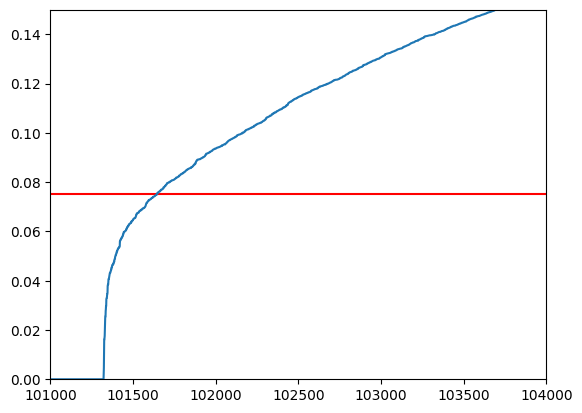

In [12]:
sorted_distances = np.sort(distances, axis=0)
items = sorted_distances[:,1]
plt.xlim([101000, 104000])
plt.ylim([0.0, 0.15])
plt.axhline(y=0.075, color='r', linestyle='-')
plt.plot(items)


# https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

In [13]:
db = DBSCAN(eps=0.075, min_samples=99, algorithm='auto', n_jobs=4).fit(X)

labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 139
Estimated number of noise points: 62465


In [14]:
idx = np.argsort(db.core_sample_indices_)
core_samples = np.zeros_like(labels, dtype=bool)
core_samples[db.core_sample_indices_[idx]] = True


def get_clustered_sentences(labels, sentences):
    clustered_sentences = defaultdict(list)
    for sentence_id, cluster_id in enumerate(labels):
        if cluster_id >= 0:
            clustered_sentences[cluster_id].append(sentences[sentence_id])
    return clustered_sentences


clustered_sentences = get_clustered_sentences(labels, sample)

print(len(clustered_sentences))
print(clustered_sentences.keys())


# for cluster_id, sentences in clustered_sentences.items():
#     print(f"Cluster {cluster_id}:")
#     print(sentences[:10])
#     print()


139
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 138, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137])


In [15]:
# 1-D swarmplot
# sns.swarmplot(x=clusters_count['phrase'], color="red")

In [16]:
for i in range(n_clusters_):
    print("Cluster %d:" % i),
    print("Cluster size: %d" % len(clustered_sentences[i]))

    set_phrases = set(clustered_sentences[i])

    for phr in random.sample(set_phrases,min(20, len(set_phrases))):
        print("  %s" % phr)
    print("\n")


Cluster 0:
Cluster size: 224
  servidor lotado abaete necessita resolver pendencias localmente
  conducao servidor deslocara presidente venceslau levar ac ppe treinamento agua lindoia
  servidor prestacao contas pendente
  servidor pendencia prestacao contas anterior
  servidor ronaldo neve moura filho chefe assessoria internacional representa brasil missoes internacionais nome anatel
  acompanhar corpo servidor falecido marido
  servidor nomeado pro reitor
  servidor regularizando prestacao contas anterior
  transportar servidor pierre george sousa realize reunioes area municipios cg esperanca itabaiana conde sume
  servidor realizou
  servidor contratado
  servidor pendencias prestacao contas anteriores
  servidor substituindo outro
  servidor retornando
  servidor designado
  transportar servidor pierre george sousa realize reunioes area municipios cg esperanca itabaiana
  titular substituto servidor
  conserto instalacao equipamentos informatica transferencia dado servidor problema

/tmp/ipykernel_3004/3344563523.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for phr in random.sample(set_phrases,min(20, len(set_phrases))):


In [17]:
#http://datamining.rutgers.edu/publication/internalmeasures.pdf

## Silhouette Coefficient

In [18]:
metrics.silhouette_score(X, labels, metric='euclidean', sample_size=120000, random_state=42)

0.2158398158270821

## Calinski-Harabasz Index

In [19]:
metrics.calinski_harabasz_score(X, labels)

743.350117593332

## Davies-Bouldin Index

In [20]:
metrics.davies_bouldin_score(X, labels)

1.0029843998490324